In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
%matplotlib inline 

###Part 1: Total Infection

Here we assume that students are only connected to their coaches and coaches are only connected to their students. Thus, we model this as a simple, undirected graph. We know that:
1. If B coaches C, then C should get the new feature as well. 
2. Infections are transferred by both the “coaches” and “is coached by” relations.

Thus, if someone is infected, so is everyone he/she is connected to in the graph. This is the case recursively until we have an entire connected component.

In [126]:
def total_infection(user, network):
    #infect the user
    network.node[user]['infected'] = True
    neighbors = network.neighbors(user)
    print neighbors
    for neighbor in neighbors:
        # only run total_infection() on uninfected neighbors; otherwise, infinite loop
        if network.node[neighbor]['infected'] == False:
            total_infection(neighbor, network)

Now we run a test case, assuming that the only connections are coaching ones. While the coaching relationship could be modeled through a directed graph with arrows pointing from the coach to the student, we model the network at the moment as an undirected graph because it functions as such in the case of the infections.

In [132]:
#Create a directed graph to model the coaching relationships (for use in the visualizations)
network=nx.DiGraph()
network.add_nodes_from(["A","B","C"], infected=False)
network.add_nodes_from(['a','b','c','d','e'], infected=False)
network.add_edges_from([("A",'b'), ('A','c'), ("B",'b'),("B",'c'),("C",'d'),("C",'e')])
#create a deep copy of an undirected graph for use in the function total_infection()
networka = network.to_undirected()

In [133]:
total_infection("A",networka)
#output the results
networka.nodes(True)

['c', 'b']
['A', 'B']
['c', 'b']
['A', 'B']


[('A', {'infected': True}),
 ('a', {'infected': False}),
 ('C', {'infected': False}),
 ('B', {'infected': True}),
 ('e', {'infected': False}),
 ('d', {'infected': False}),
 ('c', {'infected': True}),
 ('b', {'infected': True})]

###Part 2: Limited Infection

Since the point of an infection would be to be able to A/B test while not grossly harming users' experiences, instead of infecting based on an arbitrary threshold starting from a random user, we first analyse the graph itself to choose our parameters for limited_infection().

We imagine the graph of our users to look like a graph made of several connected components (with the exception of a graph where all the users are connected; however, as specified in the prompt, this is pretty unrealistic). We measure the number of nodes (i.e. users) in a connected component before determining if we want to infect the entire connected component (based on whether the size of the connected component is within a certain threshold range). If it is not, we measure the size of the next connected component. When we have found an appropriate connected component (or combination of connected components), we infect all the nodes in that component/those components. If we do not find an appropriate sized connected component (or combination of connected components), the function fails.

This ensures that a coach and all his/her students will have a feature, while also allowing for a reasonable size of the treatment (and control) group in the A/B test.

In [17]:
#need to have multiple components to add up to the threshold
def find_connected_component(cmpts, user, network):
    cmpts.append(user)
    neighbors = network.neighbors(user)
    for neighbor in neighbors:
        if neighbor not in cmpts:
            cmpts = find_connected_component(cmpts,neighbor, network)
    return cmpts
        

def limited_infection(min_threshold, max_threshold, network):
    #find an appropriate connected component with find_connected_network
    user = np.random.choice(network.nodes())
    cmpts = find_connected_component([],user, network)
    num_cmpts = len(cmpts)
    num_tested = num_cmpts
    network_length = len(network.nodes())
    #split the min and max
    while num_cmpts < min_threshold or num_cmpts > max_threshold:
        #if no connected components meet this criteria and we have iterated through all of them
        if num_tested==network_length:
            raise ValueError("Limited infection not possible for this network.")
        while user in cmpts:
            user = np.random.choice(network.nodes())
        cmpts = find_connected_component([],user, network)
        num_cmpts = len(cmpts)
        num_tested +=num_cmpts
    #set the attributes of the nodes in the first connected component that satisfies the constraints
    nx.set_node_attributes(network, "infected", dict(zip(cmpts, np.repeat(True,num_cmpts))))

In [6]:
#works recursively to find all the nodes in the connected component
def find_connected_component(cmpts, user, network):
    cmpts.append(user)
    neighbors = network.neighbors(user)
    for neighbor in neighbors:
        if neighbor not in cmpts:
            cmpts = find_connected_component(cmpts,neighbor, network)
    return cmpts
        
    
#if a combination summing to the infection size is found, return the component sizes 
#otherwise, return sub_sums with the new subsum combinations appended to the list of lists
def add_to_sub_sums(num, sub_sums, infect_num):
    for sub_sum in sub_sums:
        #if the combination does sum up to the infection size, return the component sizes
        if sum(sub_sum)+num == infect_num:
            return [sub_sum.extend([num])]
        #else, only add the combination if the sum of the sub_sum list plus num is 
        #less than our desired infection size
        elif sum(sub_sum)+num < infect_num:
            sub_sums.append(sub_sum.extend([num]))
    return sub_sums

#infect a component given the component size
def infect_cmpt(network, cmpts_list, num_list, num):
    cmpts_to_infect = cmpts_list[num_list.index(num)]
    nx.set_node_attributes(network, "infected", dict(zip(cmpts_to_infect, np.repeat(True,len(cmpts_to_infect)))))

#this function finds all connected components and their sizes
#then finds an appropriate combination of connected components to infect (the first combination that works)
def limited_infection(infect_num, network):
    network_length = len(network.nodes())
    if infect_num > network_length:
        raise ValueError("The infection size exceeds the network length.")
    #start with a connected component from a random user
    user = np.random.choice(network.nodes())
    cmpts = find_connected_component([],user, network)
    num_cmpts = len(cmpts)
    #this counter keeps track of how many nodes we have already looked at
    num_tested = num_cmpts
    
    
    #create two lists storing the connected components and their lengths
    #this is a list of lists for the connected components
    cmpts_list = [cmpts]
    #this is a list for the sizes
    num_list = [num_cmpts]
    
    #find all the connected components in the network
    while num_tested < network_length:
        #flatten the list of lists to a list to iterate
        flattened_list = [cmpt for cmpts in cmpts_list for cmpt in cmpts]
        #find a random user from another component of the network not already looked at
        while user in flattened_list:
            user = np.random.choice(network.nodes())
        #find the connectd component the user belongs to
        cmpts = find_connected_component([],user, network)
        num_cmpts = len(cmpts)
        #increase the counter keeping track of the nodes accounted for in the iterations
        num_tested +=num_cmpts
        #append the connected components and their sizes to the list
        cmpts_list.append(cmpts)
        num_list.append(num_cmpts)
    
    #choose a combination of connected components that satisfy the constraints
    #define an empty list of the cmpts
    cmpt_list_to_infect = []
    sorted_num_list = sorted(num_list)
    #sub_sums will be a list of lists containing the various combinations of components to add together
    sub_sums = []
    #iterate through each connected component size
    for num in sorted_num_list:
        #if the size of the component is exactly the infection size, infect the component
        if num == infect_num:
            infect_cmpt(network, cmpts_list, num_list, num)
            return "Successfully infected component"
        #if the connected component size is greater than the infection size we want, so must every subsequent component
        if num > infect_num:
            break
        #for each component size (here, num), add to sub_sum the lists of every existing combination plus num 
        if sub_sums:
            subsums = add_to_sub_sums(num, sub_sums, infect_num)
            #if add_to_sub_sums() returns the exact combination summing to the infection size,
            #infect those connected components
            if len(sub_sums)==1:
                for num in sub_sums[0]:
                    infect_cmpt(network, cmpts_list, num_list, num)
                return "Successfully infected components"
        #add num by itself as a combination to sub_sum
        sub_sums.append([num])
    print "sub_sums", sub_sums
    #if out of the loop, there is no combination summing exactly to the infection sum
    return "Not able to infect exact number of users."                                

We use a similarly structured graph for our testing this time as well.

In [7]:
network1=nx.DiGraph()
network1.add_nodes_from(["A","B","C"], infected=False)
network1.add_nodes_from(['a','b','c','d','e'], infected=False)
network1.add_edges_from([("A",'b'), ('A','c'), ("B",'b'),("B",'c'),("C",'d'),("C",'e')])
network1a = network1.to_undirected()

In [8]:
limited_infection(4,network1a)

'Successfully infected components'

In [9]:
network1a.nodes(True)

[('A', {'infected': False}),
 ('a', {'infected': True}),
 ('C', {'infected': True}),
 ('B', {'infected': False}),
 ('e', {'infected': True}),
 ('d', {'infected': True}),
 ('c', {'infected': False}),
 ('b', {'infected': False})]

###Visualization

The following is a visualization of the network after the implementation of full_infection(). This visualization uses the Fruchterman-Reingold force-directed algorithm, where the red nodes denote infected and green nodes unaffected.

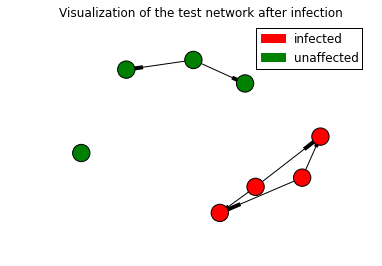

In [149]:
#note: here we use information from both the pre-infection directed graph and the post-infection undirected graph
#specifically, we take the node data from networka and the edge data from network

#Position nodes using Fruchterman-Reingold force-directed algorithm
pos=nx.spring_layout(networka)

node_color = []
#determine the sequence of colors for the nodes
for node in networka.nodes(data=True):
    #infected nodes are red
    if node[1]['infected']:
        node_color.append('r')
    #uninfected nodes are green
    else:
        node_color.append('g')

nx.draw_networkx_nodes(networka, pos,node_color=node_color)
nx.draw_networkx_edges(network,pos,arrows=True)
plt.axis('off')
plt.title('Visualization of the test network after total infection')


#create a legend
infected_lab = mpatches.Patch(color='red', label='infected')
unaffected_lab = mpatches.Patch(color='green', label='unaffected')
plt.legend(handles=[infected_lab, unaffected_lab], loc=0)
#where it began

###To do with extra time

With extra time, I would love to:
    1. Improve the algorithm in limited_infection() to be more efficient and also allow leeway from the exact
    threshold. In the end, the purpose of limited infection for A/B testing is not necessarily to infect an exact
    number of users, but to get roughly appropriate sizes for the treatment and control groups. 
    2. Oftentimes, we want to test not just one feature, but multiple versions of that specific feature. Thus, I
    would also like to create a new version of limited_infection() that allows for this so that one would be able to 
    conduct multiple comparisons.
    3. Make the arrows in the visualizations more nice-looking, since they are currently just stubs.